In [1]:
from collections import Counter
import itertools
import json
import math
import os
import pickle
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import cv2
import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
np.bool = bool
import pandas as pd
from PIL import Image
import seaborn as sns
from skimage import measure, morphology, segmentation
import torch.nn as nn
from tqdm import tqdm, trange

from ldm.util import MyPool

# Load meta data

In [2]:
TOTAL_LENGTH = 247678
smc_data_path = "/scratch/users/xikunz2/stable-diffusion"
image_path = f"{smc_data_path}/hpa-webdataset-all-composite/images2"
mask_path = f"{smc_data_path}/hpa-webdataset-all-composite/masks2"
cleaned_mask_path = f"{smc_data_path}/hpa-webdataset-all-composite/cleaned_masks"
with open(f"{smc_data_path}/hpa-webdataset-all-composite/HPACombineDatasetInfo.pickle", 'rb') as fp:
    info_list = pickle.load(fp)
assert len(info_list) == TOTAL_LENGTH

In [3]:
info_list[0]

{'filename': '/archive/1680/1680_F4_5_',
 'if_plate_id': 1680,
 'position': 'F4',
 'sample': 5,
 'status': 35,
 'Image status name': 'Annotated / Proteinatlas',
 'locations': 'Cell Junctions',
 'staining characteristics': nan,
 'unspecific': 0.0,
 'antibody': 'HPA077995',
 'ensembl_ids': 'ENSG00000253537',
 'gene_names': 'PCDHGA7',
 'atlas_name': 'SH-SY5Y',
 'versions': '16.0,16.1,17.0',
 'earliest_version': 16.0,
 'first_released': '2016-12-04 14:00:00',
 'latest_version': 17.0,
 'Spatial cell cycle': nan,
 'Intensity cell cycle': nan,
 'Annotated cell cycle': 0.0,
 'gain': 800.0,
 'Ab state': 'IF_FAILED',
 'Max tpm': 19.76,
 'Finished in genes': nan,
 'Protocol': 'PFA',
 'Gene reliability (in release)': nan,
 'Gene reliability (lims)': nan,
 'Cell count': 24.0,
 'well_location_predictions_all': nan,
 'image_id': '77995_1680_F4_5',
 'sequences': ['>sp|Q9Y5G6|PCDG7_HUMAN Protocadherin gamma-A7 OS=Homo sapiens OX=9606 GN=PCDHGA7 PE=2 SV=1\nMAAQPRGGDYRGFFLLSILLGTPWEAWAGRILYSVSEETDKGSFVGD

In [4]:
with open(f"{smc_data_path}/hpa-webdataset-all-composite/stage1_data_split_flt4.json") as in_file:
    idcs = json.load(in_file)
train_indexes = idcs["train"]
valid_indexes = idcs["validation"]
all_indexes = train_indexes + valid_indexes
print(len(all_indexes), len(train_indexes))
filtered_info_list = [info_list[idx] for idx in all_indexes]

73236 69800


# Get segmentation masks

In [5]:
def get_masks(segmentator, image_path, mask_path):
    # for idx, row in tqdm(no_mask_df.iterrows(), total=len(no_mask_df)):
    c = 0
    for idx in tqdm(all_indexes):
        info = info_list[idx]
        plate_id = info["if_plate_id"]
        position = info["position"]
        sample = info["sample"]
        name_str = str(plate_id) + "_" + str(position) + "_" + str(sample)
        if not os.path.exists(f"{mask_path}/{name_str}_cellmask.png") or not os.path.exists(f"{mask_path}/{name_str}_nucleimask.png"):
            c += 1
            im = Image.open(f'{image_path}/{idx}.tif')
            imarray = np.array(im)
            assert imarray.shape == (1024, 1024, 4)
            image_mt, image_er, image_nuc = imarray[:, :, 0], imarray[:, :, 3], imarray[:, :, 2]

            image = [[image_mt], [image_er], [image_nuc]]

            nuc_segmentation = segmentator.pred_nuclei(image[2])
            cell_segmentation = segmentator.pred_cells(image)

            # post-processing
            nuclei_mask = label_nuclei(nuc_segmentation[0])
            nuclei_mask, cell_mask = label_cell(nuc_segmentation[0], cell_segmentation[0])

            assert np.max(nuclei_mask) > 0 and np.max(cell_mask) > 0, f"No nuclei or cell mask found for {idx}"
            # fig, axes = plt.subplots(1, 2)
            # axes[0].imshow(nuclei_mask)
            # axes[1].imshow(cell_mask)

            im = Image.fromarray(cell_mask)
            im.save(f"{mask_path}/{name_str}_cellmask.png")
            im = Image.fromarray(nuclei_mask)
            im.save(f"{mask_path}/{name_str}_nucleimask.png")
            # break
    print(c)


NUC_MODEL = f"{smc_data_path}/nuclei_model.pth"
CELL_MODEL = f"{smc_data_path}/cell_model.pth"
segmentor = cellsegmentator.CellSegmentator(
    NUC_MODEL, CELL_MODEL, device="cuda", padding=True, multi_channel_model=True, scale_factor=0.5
)
for m in itertools.chain(segmentor.nuclei_model.modules(), segmentor.cell_model.modules()):
    if isinstance(m, nn.Upsample):
        m.recompute_scale_factor = None
# get_masks(segmentor, image_path, mask_path)

please compile abn


/home/groups/emmalu/xikunz2/miniconda3/envs/ldm2/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'pytorch_zoo.unet.DPNUnet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/groups/emmalu/xikunz2/miniconda3/envs/ldm2/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/groups/emmalu/xikunz2/miniconda3/envs/ldm2/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.Se

# Clean up segmentation masks and get bounding box coordinates

In [7]:
def clean_up_masks(
    cell_mask,
    nuclei_mask,
    closing_radius=7,
    rm_border=True,
    remove_size=1000,
    merge_nuclei=True
):
    init_total_labels = len(np.unique(nuclei_mask)) - 1

    if rm_border:
        nuclei_mask = segmentation.clear_border(nuclei_mask, buffer_size=5)
        keep_value = np.unique(nuclei_mask)
        # borderedcellmask = np.array([[x_ in keep_value for x_ in x] for x in cell_mask]).astype("uint8")
        borderedcellmask = np.isin(cell_mask, keep_value).astype("uint8")
        cell_mask = cell_mask * borderedcellmask
        num_removed_border = init_total_labels - len(keep_value) + 1
        # print(f"Removed {num_removed} cells from border out of {init_total_labels} cells", flush=True)

    if merge_nuclei:
        ### see if nuclei are touching and merge them
        bin_nuc_mask = nuclei_mask > 0
        cls_nuc = morphology.closing(bin_nuc_mask, morphology.disk(closing_radius))
        # get the labels of touching nuclei
        new_label_map = morphology.label(cls_nuc)
        new_label_idx = np.unique(new_label_map)[1:]

        new_cell_mask = np.zeros_like(cell_mask)
        new_nuc_mask = np.zeros_like(nuclei_mask)
        for new_label in new_label_idx:
            # get the label of the touching nuclei
            old_labels = np.unique(nuclei_mask[new_label_map == new_label])
            old_labels = old_labels[old_labels != 0]

            new_nuc_mask[np.isin(nuclei_mask, old_labels)] = new_label
            new_cell_mask[np.isin(cell_mask, old_labels)] = new_label
    else:
        new_cell_mask = cell_mask
        new_nuc_mask = nuclei_mask
    num_remove_merge = init_total_labels - num_removed_border - len(np.unique(new_nuc_mask)) + 1

    # assert set(np.unique(new_nuc_mask)) == set(np.unique(new_cell_mask))

    region_props_cell = measure.regionprops(new_cell_mask, intensity_image=(new_cell_mask > 0).astype(np.uint8))
    region_props_nuc = measure.regionprops(new_nuc_mask, intensity_image=(new_nuc_mask > 0).astype(np.uint8))

    region_props = [region_props_cell[i] for (i, x) in enumerate(region_props_nuc) if x.area > remove_size]
    # print(f"Removed {len(region_props_cell) - len(region_props)} out of {len(region_props_cell)} cells", flush=True)
    num_remove_size = len(region_props_cell) - len(region_props)

    assert init_total_labels - num_removed_border - num_remove_merge - num_remove_size == len(region_props), (  # noqa
        init_total_labels,
        num_removed_border,
        num_remove_merge,
        num_remove_size,
        len(region_props),
    )

    if len(region_props) == 0:
        return new_cell_mask, new_nuc_mask, None, None, None, None, None, None
    else:
        bbox_array = np.array([x.bbox for x in region_props])
        ## convert x1,y1,x2,y2 to x,y,w,h
        bbox_array[:, 2] = bbox_array[:, 2] - bbox_array[:, 0]
        bbox_array[:, 3] = bbox_array[:, 3] - bbox_array[:, 1]

        com_array = np.array([x.weighted_centroid for x in region_props])
        bbox_label = np.array([x.label for x in region_props])

        cell_area = np.array([x.area for x in region_props])
        nuc_area = np.array([x.area for x in region_props_nuc if x.area > remove_size])
        return (
            new_cell_mask,
            new_nuc_mask,
            bbox_array, # [y, x, height, width], each bbox is [y:y+height, x:x+height]
            com_array, # [com_y, com_x]
            bbox_label,
            cell_area,
            nuc_area,
            [
                num_removed_border,
                num_remove_merge,
                num_remove_size,
            ],
        )

def get_bbox_coords(info):
    plate_id = info["if_plate_id"]
    position = info["position"]
    sample = info["sample"]
    name_str = str(plate_id) + "_" + str(position) + "_" + str(sample)
    if not os.path.exists(f"{cleaned_mask_path}/{name_str}_cellmask.png") or not os.path.exists(f"{cleaned_mask_path}/{name_str}_nucleimask.png"):
        im = Image.open(f"{mask_path}/{name_str}_cellmask.png")
        cell_mask = np.array(im)
        im = Image.open(f"{mask_path}/{name_str}_nucleimask.png")
        nuclei_mask = np.array(im)
        new_cell_mask, new_nuc_mask, bbox_array, com_array, bbox_label, cell_area, nuc_area, removed = clean_up_masks(
            cell_mask, nuclei_mask)
        im = Image.fromarray(new_cell_mask)
        im.save(f"{cleaned_mask_path}/{name_str}_cellmask.png")
        im = Image.fromarray(new_nuc_mask)
        im.save(f"{cleaned_mask_path}/{name_str}_nucleimask.png")
        return bbox_array, com_array, bbox_label, cell_area, nuc_area, removed

# n_cpus = os.cpu_count() - 1
# with MyPool(n_cpus, chunksize=16, initializer=None, initargs=None) as p:
#     bbox_coords_list = list(tqdm(p.map_func(get_bbox_coords, filtered_info_list), total=len(all_indexes)))
repr(get_bbox_coords(filtered_info_list[0]))

'None'

In [40]:
# with open(f"{smc_data_path}/hpa-webdataset-all-composite/bbox_coords.pkl", "wb") as out_file:
#     pickle.dump(bbox_coords_list, out_file)

In [8]:
with open(f"{smc_data_path}/hpa-webdataset-all-composite/bbox_coords.pkl", "rb") as in_file:
    bbox_coords_list = pickle.load(in_file)
len(bbox_coords_list), bbox_coords_list[:2]

(73236,
 [(array([[   0,   38,  508,  703],
          [ 183,  502,  768,  667],
          [ 403,  746,  987,  835],
          [ 862, 1192,  652,  856],
          [ 854,  338,  804,  875],
          [1382,    0,  666, 1057],
          [1439,  912,  595, 1070]]),
   array([[ 222.11757296,  389.83289266],
          [ 539.22771448,  816.42089049],
          [ 910.21881623, 1202.24126592],
          [1202.16106162, 1643.91695371],
          [1292.77677483,  755.00036318],
          [1766.51552694,  489.23815901],
          [1760.02162034, 1498.27843554]]),
   array([1, 2, 3, 4, 5, 6, 7]),
   array([256428, 291501, 296797, 408471, 415773, 466705, 459891]),
   array([38560, 53040, 43808, 55088, 76512, 70416, 62736]),
   [3, 0, 0]),
  (array([[  0,  43, 306, 505],
          [ 62, 412, 291, 298],
          [176, 682, 262, 188],
          [140, 196, 214, 218],
          [278,   0, 134, 294],
          [355, 366, 485, 228],
          [394, 773, 532, 251],
          [300, 482, 388, 208],
         

In [9]:
assert len(filtered_info_list) == len(bbox_coords_list)
def scale_bboxes(inputs):
    info, (bbox_array, com_array, bbox_label, cell_area, nuc_area, removed) = inputs
    plate_id = info["if_plate_id"]
    position = info["position"]
    sample = info["sample"]
    name_str = str(plate_id) + "_" + str(position) + "_" + str(sample)
    cellline = info["atlas_name"]
    if com_array is None:
        return [], [], [], [], [], [], [], [], []
    else:
        image_id_list = [name_str] * len(com_array)
        cellline_list = [cellline] * len(com_array)
        im = Image.open(f"{mask_path}/{name_str}_cellmask.png")
        cell_mask = np.array(im)
        im = Image.open(f"{mask_path}/{name_str}_nucleimask.png")
        nuclei_mask = np.array(im)
        assert cell_mask.shape == nuclei_mask.shape
        downsample_factors = cell_mask.shape / np.array([1024, 1024])
        adjusted_com_array = com_array / downsample_factors
        # print(adjusted_com_array)
        com_y_list = adjusted_com_array[:, 0].tolist()
        com_x_list = adjusted_com_array[:, 1].tolist()
        bbox_y_list = (bbox_array[:, 0] / downsample_factors[0]).tolist()
        bbox_x_list = (bbox_array[:, 1] / downsample_factors[1]).tolist()
        bbox_height_list = (bbox_array[:, 2] / downsample_factors[0]).tolist()
        bbox_width_list = (bbox_array[:, 3] / downsample_factors[1]).tolist()
        bbox_label_list = bbox_label.tolist()
        return image_id_list, cellline_list, com_y_list, com_x_list, bbox_y_list, bbox_x_list, bbox_height_list, bbox_width_list, bbox_label_list

n_cpus = os.cpu_count() - 1
with MyPool(n_cpus, chunksize=16, initializer=None, initargs=None) as p:
    scaled_bboxes_list = list(tqdm(p.map_func(scale_bboxes, zip(filtered_info_list, bbox_coords_list)), total=len(all_indexes)))
# scale_bboxes((filtered_info_list[0], bbox_coords_list[0]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 73236/73236 [04:48<00:00, 253.69it/s]


In [10]:
len(scaled_bboxes_list)

73236

In [17]:
import torch
t = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8]])
torch.split(t, 1, dim=1)

(tensor([[1],
         [5]]),
 tensor([[2],
         [6]]),
 tensor([[3],
         [7]]),
 tensor([[4],
         [8]]))

In [11]:
image_id_list, cellline_list, com_y_list, com_x_list, bbox_y_list, bbox_x_list, bbox_height_list, bbox_width_list, bbox_label_list = [[] for _ in range(9)]
for image_id_list_, cellline_list_, com_y_list_, com_x_list_, bbox_y_list_, bbox_x_list_, bbox_height_list_, bbox_width_list_, bbox_label_list_ in scaled_bboxes_list:
    image_id_list.extend(image_id_list_)
    cellline_list.extend(cellline_list_)
    com_y_list.extend(com_y_list_)
    com_x_list.extend(com_x_list_)
    bbox_y_list.extend(bbox_y_list_)
    bbox_x_list.extend(bbox_x_list_)
    bbox_height_list.extend(bbox_height_list_)
    bbox_width_list.extend(bbox_width_list_)
    bbox_label_list.extend(bbox_label_list_)
scaled_bboxes_df = pd.DataFrame({"image_id": image_id_list, "bbox_label": bbox_label_list, "cell_line": cellline_list, "com_y": com_y_list, "com_x": com_x_list, "bbox_y": bbox_y_list, "bbox_x": bbox_x_list, "bbox_height": bbox_height_list, "bbox_width": bbox_width_list})
scaled_bboxes_df

,image_id,bbox_label,cell_line,com_y,com_x,bbox_y,bbox_x,bbox_height,bbox_width
0,1029_F8_1,1,A-431,111.058786,194.916446,0.000000,19.000000,254.000000,351.500000
1,1029_F8_1,2,A-431,269.613857,408.210445,91.500000,251.000000,384.000000,333.500000
2,1029_F8_1,3,A-431,455.109408,601.120633,201.500000,373.000000,493.500000,417.500000
3,1029_F8_1,4,A-431,601.080531,821.958477,431.000000,596.000000,326.000000,428.000000
4,1029_F8_1,5,A-431,646.388387,377.500182,427.000000,169.000000,402.000000,437.500000
...,...,...,...,...,...,...,...,...,...
1011992,36_F2_2,3,A-431,477.487145,766.996744,314.666667,672.592593,286.222222,177.185185
1011993,36_F2_2,4,A-431,489.121995,374.171645,363.851852,226.370370,300.444444,359.703704
1011994,36_F2_2,5,A-431,557.857688,510.815798,418.370370,330.666667,290.962963,350.222222
1011995,36_F2_2,6,A-431,755.140542,263.210319,660.148148,148.740741,187.259259,234.074074


In [14]:
imageid2idx = dict()
for idx in tqdm(all_indexes):
    info = info_list[idx]
    plate_id = info["if_plate_id"]
    position = info["position"]
    sample = info["sample"]
    name_str = str(plate_id) + "_" + str(position) + "_" + str(sample)
    imageid2idx[name_str] = idx
scaled_bboxes_df["hpa_index"] = scaled_bboxes_df["image_id"].apply(lambda x: imageid2idx[x])
scaled_bboxes_df

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 73236/73236 [00:00<00:00, 647378.65it/s]


,image_id,bbox_label,cell_line,com_y,com_x,bbox_y,bbox_x,bbox_height,bbox_width,hpa_index
0,1029_F8_1,1,A-431,111.058786,194.916446,0.000000,19.000000,254.000000,351.500000,131072
1,1029_F8_1,2,A-431,269.613857,408.210445,91.500000,251.000000,384.000000,333.500000,131072
2,1029_F8_1,3,A-431,455.109408,601.120633,201.500000,373.000000,493.500000,417.500000,131072
3,1029_F8_1,4,A-431,601.080531,821.958477,431.000000,596.000000,326.000000,428.000000,131072
4,1029_F8_1,5,A-431,646.388387,377.500182,427.000000,169.000000,402.000000,437.500000,131072
...,...,...,...,...,...,...,...,...,...,...
1011992,36_F2_2,3,A-431,477.487145,766.996744,314.666667,672.592593,286.222222,177.185185,204799
1011993,36_F2_2,4,A-431,489.121995,374.171645,363.851852,226.370370,300.444444,359.703704,204799
1011994,36_F2_2,5,A-431,557.857688,510.815798,418.370370,330.666667,290.962963,350.222222,204799
1011995,36_F2_2,6,A-431,755.140542,263.210319,660.148148,148.740741,187.259259,234.074074,204799


In [15]:
# scaled_bboxes_df.to_csv(f"{smc_data_path}/hpa-webdataset-all-composite/scaled_bboxes.csv")

# Plot the distribution of cell sizes

In [12]:
scaled_bboxes_df["cell_line"].unique()

array(['A-431', 'U-251 MG', 'U-2 OS', 'MCF7', 'HaCaT', 'CACO-2', 'RT4',
       'A549', 'HeLa', 'NIH 3T3', 'REH', 'SiHa', 'Hep G2', 'BJ',
       'HEK 293', 'PC-3', 'HTC', 'SH-SY5Y', 'RH-30', 'Vero', 'SK-MEL-30',
       'RPTEC TERT1', 'NB-4', 'EFO-21', 'HEL', 'K-562', 'AF22',
       'HUVEC TERT2', 'THP-1', 'hTCEpi', 'ASC TERT1', 'LHCN-M2', 'HAP1'],
      dtype=object)

In [12]:
scaled_bboxes_df[scaled_bboxes_df["bbox_height"] == 1024]

,image_id,cell_line,com_y,com_x,bbox_y,bbox_x,bbox_height,bbox_width
1623,1544_H10_2,BJ,539.138324,203.679937,0.0,0.000000,1024.0,536.000000
3094,1446_H10_1,BJ,560.285604,478.933982,0.0,0.000000,1024.0,1024.000000
22844,1154_A6_3,U-2 OS,679.765045,883.055452,0.0,639.000000,1024.0,385.000000
23117,1749_C9_18,ASC TERT1,487.978170,644.503467,0.0,163.333333,1024.0,860.666667
25392,620_A11_3,U-2 OS,373.893596,463.618881,0.0,331.000000,1024.0,296.500000
...,...,...,...,...,...,...,...,...
990082,1866_G5_35,BJ,599.492879,232.218890,0.0,0.000000,1024.0,686.500000
990083,1866_G5_35,BJ,521.392470,902.160783,0.0,708.000000,1024.0,316.000000
993858,1368_A9_4,BJ,468.748397,815.378274,0.0,519.500000,1024.0,504.500000
993859,1368_A9_4,BJ,546.726233,195.584198,0.0,0.000000,1024.0,452.500000


In [13]:
scaled_bboxes_df[scaled_bboxes_df["bbox_width"] == 1024]

,image_id,cell_line,com_y,com_x,bbox_y,bbox_x,bbox_height,bbox_width
3094,1446_H10_1,BJ,560.285604,478.933982,0.000000,0.0,1024.000000,1024.0
9503,1368_H6_2,BJ,556.889631,693.569437,333.500000,0.0,416.500000,1024.0
9505,1368_H6_2,BJ,875.782634,546.074211,671.000000,0.0,353.000000,1024.0
12039,1331_C6_1,BJ,301.423888,681.858714,0.000000,0.0,685.500000,1024.0
12041,1331_C6_1,BJ,564.091016,487.561060,359.000000,0.0,415.500000,1024.0
...,...,...,...,...,...,...,...,...
992641,1544_E12_9,BJ,774.176562,559.619032,484.000000,0.0,540.000000,1024.0
995206,152_A10_2,U-251 MG,664.324282,672.551063,295.111111,0.0,625.777778,1024.0
998678,613_B10_3,U-2 OS,916.999655,387.590287,652.000000,0.0,372.000000,1024.0
1005845,441_G4_1,A-431,112.161420,658.378049,0.000000,0.0,350.500000,1024.0


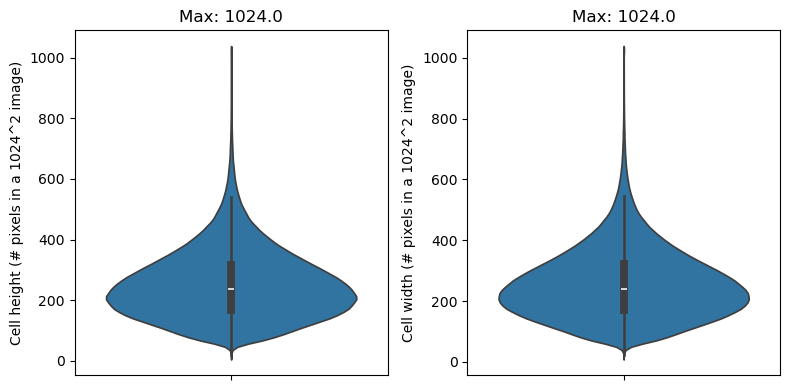

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes[0]
sns.violinplot(bbox_height_list, ax=ax)
ax.set_ylabel("Cell height (# pixels in a 1024^2 image)")
ax.set_title(f"Max: {max(bbox_height_list)}")
ax = axes[1]
sns.violinplot(bbox_width_list, ax=ax)
ax.set_ylabel("Cell width (# pixels in a 1024^2 image)")
ax.set_title(f"Max: {max(bbox_width_list)}")
fig.tight_layout()

Text(0, 0.5, '#cells smaller than 256^2 in a 1024^2 image')

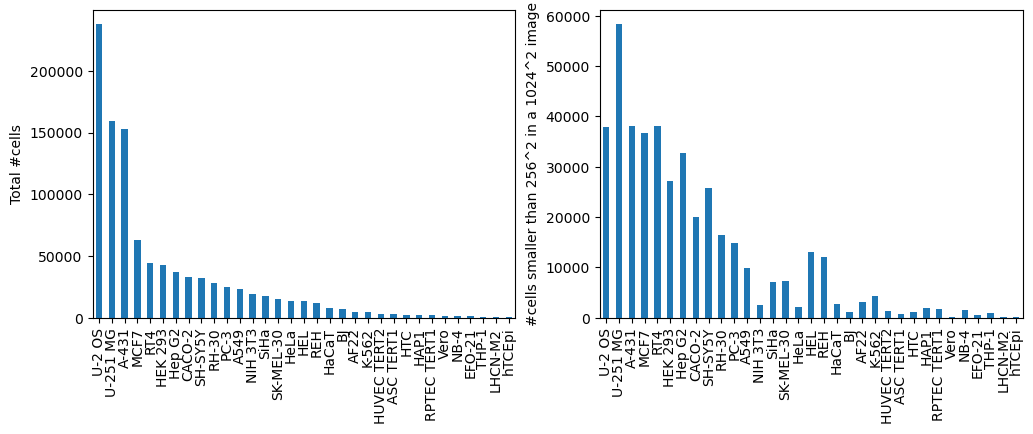

In [27]:
small_cells_df = scaled_bboxes_df[(scaled_bboxes_df["bbox_height"] <= 256) & (scaled_bboxes_df["bbox_width"] <= 256)]
cellline_freq = pd.Series(Counter(scaled_bboxes_df["cell_line"])).sort_values(ascending=False)
small_cells_cellline_freq = pd.Series(Counter(small_cells_df["cell_line"])).loc[cellline_freq.index]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
cellline_freq.plot(kind='bar', ax=ax)
ax.set_ylabel("Total #cells")
ax = axes[1]
small_cells_cellline_freq.plot(kind='bar', ax=ax)
ax.set_ylabel("#cells smaller than 256^2 in a 1024^2 image")

# Visualize bounding boxes

In [30]:
info = filtered_info_list[0]
plate_id = info["if_plate_id"]
position = info["position"]
sample = info["sample"]
name_str = str(plate_id) + "_" + str(position) + "_" + str(sample)
# if name_str in images_w_bboxes:
#     return None
# else:
im = Image.open(f"{mask_path}/{name_str}_cellmask.png")
cell_mask = np.array(im)
im = Image.open(f"{mask_path}/{name_str}_nucleimask.png")
nuclei_mask = np.array(im)
new_cell_mask, new_nuc_mask, bbox_array, com_array, bbox_label, cell_area, nuc_area, [num_removed_border, num_remove_merge, num_remove_size] = clean_up_masks(
    cell_mask,
    nuclei_mask)
bbox_array[0], com_array[0]

(array([  0,  38, 508, 703]), array([222.11757296, 389.83289266]))

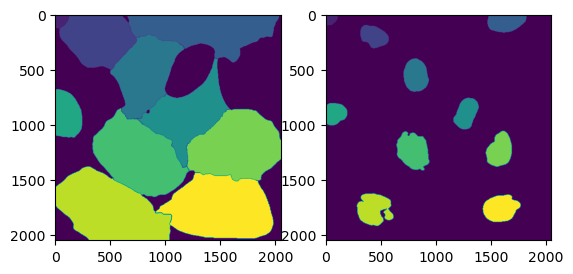

In [12]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(cell_mask)
axes[1].imshow(nuclei_mask)

In [13]:
np.unique(cell_mask), np.unique(nuclei_mask)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8))

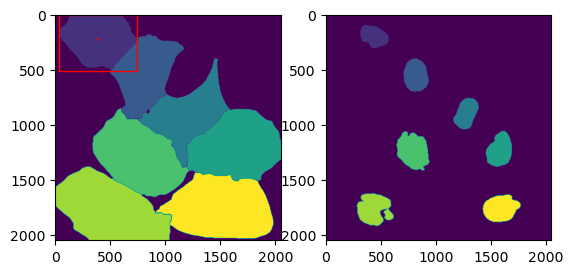

In [14]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(new_cell_mask)
axes[1].imshow(new_nuc_mask)
c = 0
# Create a Rectangle patch
for bbox, com in zip(bbox_array, com_array):
    # bbox: [y, x, height, width]
    rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3], bbox[2], linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    axes[0].add_patch(rect)
    circ = patches.Circle((com[1], com[0]), color="red")
    axes[0].add_patch(circ)
    c += 1
    if c >= 1:
        break
        

In [11]:
new_cell_mask.shape

(2048, 2048)

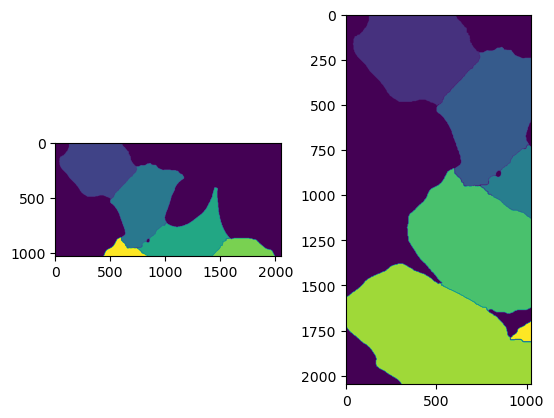

In [13]:
bbox = bbox_array[0]

fig, axes = plt.subplots(1, 2)
# axes[0].imshow(new_cell_mask[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]])
# axes[0].imshow(new_cell_mask[bbox[0]:bbox[0]+bbox[2], bbox[1]:bbox[1]+bbox[3]])
axes[0].imshow(new_cell_mask[:1024])
axes[1].imshow(new_cell_mask[:, :1024])
# axes[1].imshow(new_nuc_mask)

In [ ]:
# Each bbox:

#    [y, x] --------------- [y, x+width]
#       |                        |
#       |                        |
#       |                        |
#       |                        |
#       |                        |
#       |                        |
# [y+height, x] --------- [y+height, x+width]

# Visualize segmented cells

In [47]:
# with open(f"{smc_data_path}/one_sample.pkl", "rb") as in_file:
#     sample = pickle.load(in_file)
# sample

big_bboxes_df = scaled_bboxes_df[(scaled_bboxes_df["bbox_height"] > 512) & (scaled_bboxes_df["bbox_width"] > 512)]
image_id, com_y, com_x, bbox_y, bbox_x, bbox_height, bbox_width = big_bboxes_df.iloc[0]
im = Image.open(f'{smc_data_path}/hpa-webdataset-all-composite/images2/{image_id}.tif')
imarray = np.array(im)
imarray.shape

(1024, 1024, 4)

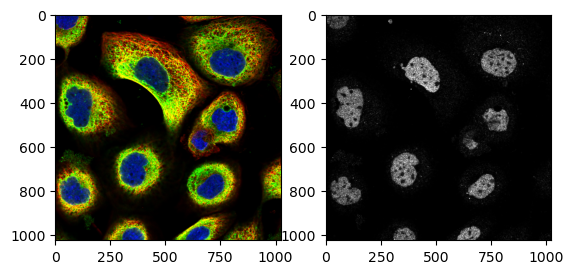

In [48]:
fig, axes = plt.subplots(1, 2)
ref = imarray[:, :, [0, 3, 2]]
prot = imarray[:, :, 1]
axes[0].imshow(ref)
axes[1].imshow(prot, cmap="gray")

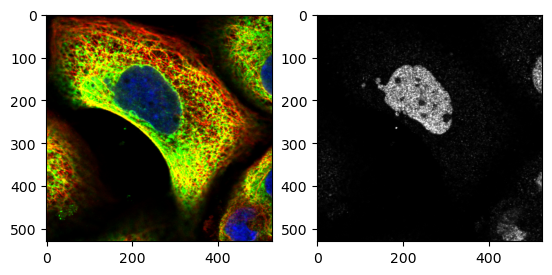

In [49]:
fig, axes = plt.subplots(1, 2)
cell_ref = ref[int(bbox_y):int(bbox_y+bbox_height), int(bbox_x):int(bbox_x+bbox_width)]
cell_prot = prot[int(bbox_y):int(bbox_y+bbox_height), int(bbox_x):int(bbox_x+bbox_width)]
axes[0].imshow(cell_ref, vmin=0, vmax=255)
axes[1].imshow(cell_prot, cmap="gray", vmin=0, vmax=255)

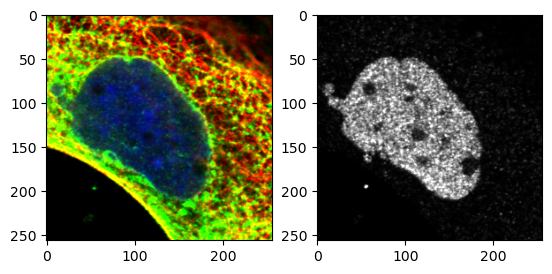

In [50]:
fig, axes = plt.subplots(1, 2)
cell_ref = ref[int(com_y)-128:int(com_y)+128, int(com_x)-128:int(com_x)+128]
cell_prot = prot[int(com_y)-128:int(com_y)+128, int(com_x)-128:int(com_x)+128]
axes[0].imshow(cell_ref, vmin=0, vmax=255)
axes[1].imshow(cell_prot, cmap="gray", vmin=0, vmax=255)

In [52]:
# with open(f"{smc_data_path}/one_sample.pkl", "rb") as in_file:
#     sample = pickle.load(in_file)
# sample

big_bboxes_df = scaled_bboxes_df[(scaled_bboxes_df["bbox_height"] == 1024) | (scaled_bboxes_df["bbox_width"] == 1024)]
image_id, com_y, com_x, bbox_y, bbox_x, bbox_height, bbox_width = big_bboxes_df.iloc[0]
im = Image.open(f'{smc_data_path}/hpa-webdataset-all-composite/images2/{image_id}.tif')
imarray = np.array(im)
imarray.shape

(1024, 1024, 4)

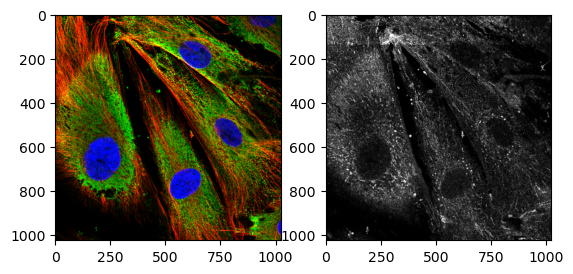

In [53]:
fig, axes = plt.subplots(1, 2)
ref = imarray[:, :, [0, 3, 2]]
prot = imarray[:, :, 1]
axes[0].imshow(ref)
axes[1].imshow(prot, cmap="gray")

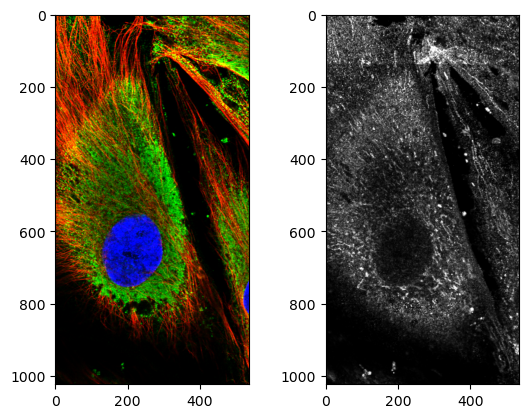

In [55]:
fig, axes = plt.subplots(1, 2)
cell_ref = ref[int(bbox_y):int(bbox_y+bbox_height), int(bbox_x):int(bbox_x+bbox_width)]
cell_prot = prot[int(bbox_y):int(bbox_y+bbox_height), int(bbox_x):int(bbox_x+bbox_width)]
axes[0].imshow(cell_ref, vmin=0, vmax=255)
axes[1].imshow(cell_prot, cmap="gray", vmin=0, vmax=255)

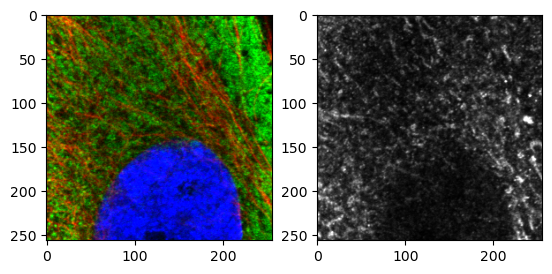

In [54]:
fig, axes = plt.subplots(1, 2)
cell_ref = ref[int(com_y)-128:int(com_y)+128, int(com_x)-128:int(com_x)+128]
cell_prot = prot[int(com_y)-128:int(com_y)+128, int(com_x)-128:int(com_x)+128]
axes[0].imshow(cell_ref, vmin=0, vmax=255)
axes[1].imshow(cell_prot, cmap="gray", vmin=0, vmax=255)

In [3]:
with open("/scratch/users/xikunz2/HPA_SingleCellClassification/kaggle-dataset/CAM_images/image_mask.pkl", "rb") as in_file:
    [image, mask] = pickle.load(in_file)
image.shape, mask.shape

((128, 128, 4), (128, 128))

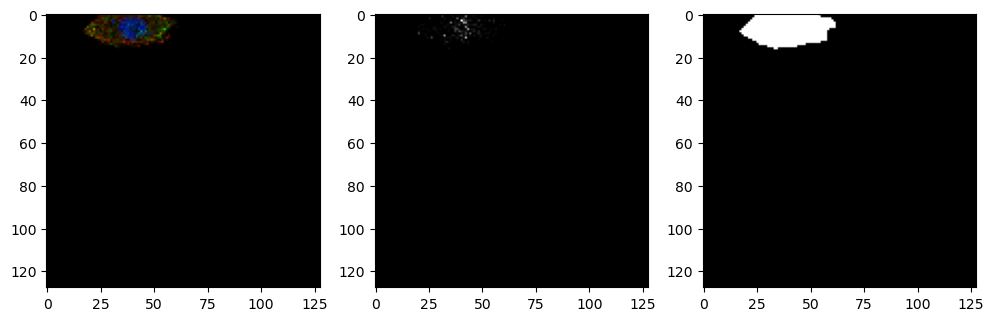

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(image[:, :, [0, 3, 2]])
axes[1].imshow(image[:, :, 1], cmap="gray")
axes[2].imshow(mask, cmap="gray")

In [10]:
top, bottom, left, right = (20, 20, 20, 20)
label_image = measure.label(mask)
label_image, label_image.shape, np.unique(label_image)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 (128, 128),
 array([0, 1]))

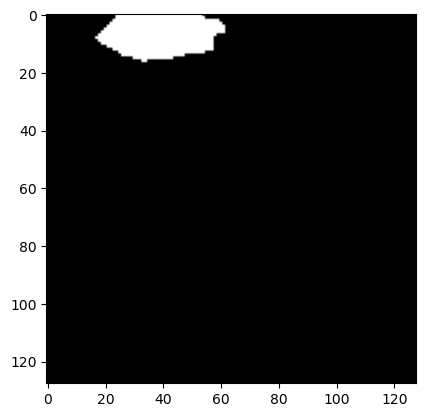

In [11]:
fig, ax = plt.subplots()
ax.imshow(label_image, cmap="gray")

In [20]:
max_area = 0
for region in measure.regionprops(label_image):
    print(region)
    if region.area > max_area:
        print(region.area, region.bbox)
        max_area = region.area
        min_row, min_col, max_row, max_col = region.bbox

min_row, min_col = max(min_row - top, 0), max(min_col - left, 0)
max_row, max_col = min(max_row + bottom, mask.shape[0]), min(max_col + right, mask.shape[1])
min_row, min_col, max_row, max_col

564 (0, 17, 17, 62)


(0, 0, 37, 82)

In [21]:
image = image[min_row:max_row, min_col:max_col]
mask = mask[min_row:max_row, min_col:max_col]

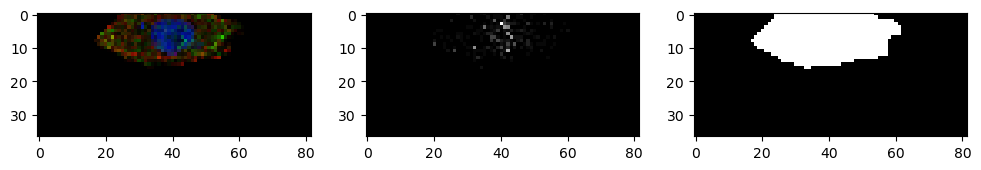

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(image[:, :, [0, 3, 2]])
axes[1].imshow(image[:, :, 1], cmap="gray")
axes[2].imshow(mask, cmap="gray")